# COVID-19 in Australia - With Adjustable Infection Rates to Represent Preventative Measures

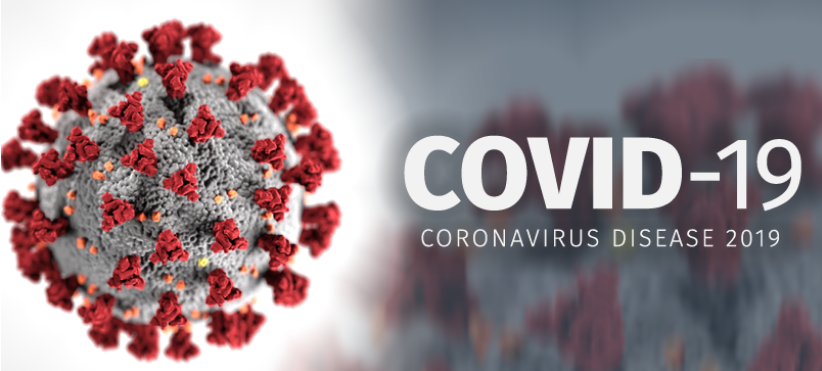

> Image Source: NEWSPORT DAILY - COVID 19 Staff Writers

Part of the difficulty with predicting infection rates is the epicurve changes brought about via response measures like quaratine and social distancing. For example, a basic R0 = 3.5 model infection model would look something like this: 

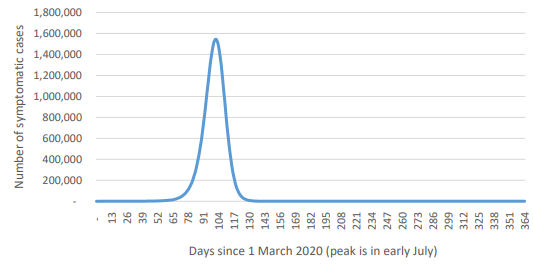

> Image Source: Potential Worse Case Health Impacts from the COVID-19 Pandemic for New Zealand if Eradication Fails: Report to the NZ Ministry of Health - COVID-19 Research Group

Let's say we start with a Basic Reproductive Number(R0) of 2.5, but implement social distancing after 40 days and we expect that will reduce the infection rate by 35%. What would that look like?


To try and answer this question I have created/modified an implementation of the SIR model using Gillespie Algorithm. I then make the infection rate adjustable for each day the pandemic lasts. It is currently modelled for the Australian population.

> **@TODO: Be aware that this notebook take a while to run (about ten minutes). I intend to try and optimize in the future for usability purposes and so it can scale to countries with much larger populations. This is the reason all the text comes before the code and the reason we only plot every 5th value in the output graphs(reduce memory use). Please bear with me until I have a chance.**

# ** Part 1: Implementing the Algorithm:**

I have detailed the implementation steps for Gillespie Algorithm below, but not an explanation of how/why it works. For this explanation have a look at these resources:

https://en.wikipedia.org/wiki/Gillespie_algorithm

https://www.youtube.com/watch?v=46ruoTTLL5g

Definitions for the purpose of this notebook:<br>
<br>
${I}$ = number of population infected <br>
${R}$ = number of the population recovered<br>
${S}$ = number of the population susceptable<br>
$\alpha$ = infection rate <br>
$\beta$ = recovery rate <br>
<br>
*Step 1 - Identify the possible events:*

This is a simple breakdown of the SIR model into it's two events

* > An infection: ${S->I}$
* > A recovery: ${I->R}$

*Step 2 - Define Update Rules:*

These rules determine the changes to the population infection status based on the randomly selected event from Step 1.
In this case:

* > For an infection event: ${I++}; {S--}$ <br>
* > For a recovery: ${I--}; {R++}$ <br>

Start Recursive steps - repeat until selected time is greater than the maximum specified time:<br>
<br>
*Step 3 - Calculate the propensities of the reactions:* <br> <br>
$$ S->I = \left( \frac{\alpha S}{N} \right){I}$$<br>
$$ I->R = \beta {I} $$ <br>

*Step 4 - Randomly choose event and perform updates:*

* > Randomly choose an event identified in Step 1. The choice is weighted by the propensities calculated in Step 3
* > Based on the random choice, use the update rules as defined in Step 2.
* > Select value to update time



# Part 2. Changing the Infection Rate:

For this step, I have only listed the most relevant parts of the Basic Reproduction Number(R0). For more background on the R0 number go here:

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

https://en.wikipedia.org/wiki/Basic_reproduction_number

So reverting back to our original problem -> if we reduce the infection rate by 35 percent after 40 days, what will the curve look like?

We will make an assumption here that the 'recovery' rate remains constant for both scenarios (remember 'recovery' is just those who have had the disease and is not nescessarily linked to survival rates). 
For the demonstration here, we use 0.1 as the recovery rate (this is just arbitarily chosen for this example).
So we know that: <br>
$$ R0 = \frac{\alpha}{\beta} $$ <br>
So to calculate our initial infection rate we re-arrange and have: <br> <br>
$$ \alpha = 2.5 \times .1 = 0.25 $$ <br>
And we are reducing that by 35 percent so our new infection rate is: <br> <br>
$$ 0.65 \times 0.25 = 0.1625 $$ 

So now we have our new infection rate at t = 40 so we can run it into the implementation below and model using the Gillespie algorithm.



In [ ]:
#Loosely based on python code available at https://en.wikipedia.org/wiki/Gillespie_algorithm

import random
import matplotlib.pyplot as plt
from math import log
import numpy as np

def model_sir_curve(recovery_rate, population, time, initial_infected, infection_rate_t ):
    
    N = population
    t_max = time
    
    #initial infected
    I = initial_infected 
    #initial recovered
    R = 0 
    #initial susceptable
    S = N - initial_infected 
    values_t = [] #basic python list - consider lower memory/higher performance solution
    values_i = [] #basic python list - consider lower memory/higher performance solution
    iterator = 0
    iterator_max = 4
    
    t=0
    while t < t_max:
        
        # find the infection rate at time t
        for i in infection_rate_t:
            if i[0] <= t and i[1] >= t:
                infection_rate = i[2]
                break
    
        if I==0:
            #no infections left
            break 
        
        #Step 3: Calculate the propensities of the reactions
        infection_constant = infection_rate * S * I / N 
        recovery_constant = (recovery_rate * I )
        constant_total = infection_constant + recovery_constant
    
        #Step 4: Choose event randomly (weighted by propensities)
        if random.uniform(0.0, 1.0) < infection_constant / constant_total :
            #we have an infection S->I
            S = S - 1
            I = I + 1
        else:
            # we have a recovery I-> R
            I = I - 1
            R = R + 1
    
        #Step 5: Choose random time
        dt = -log(random.uniform(0.0, 1.0)) / constant_total # 
        t = t + dt
        
        #dodgy hack to allow it to stay within memory bounds
        #only append every 5th calculated value to the list
        if iterator == iterator_max:
            values_t.append(t)
            values_i.append(I)
            iterator = 0
        else:
            iterator = iterator + 1
            
    return values_t, values_i

#modelling recovery rate as the same across models - 
#randomly selected -> *** needs cited value from somewhere ***
recovery_rate = 0.1

#R0 = 2.5 -> this is the baseline
baseline = "R0 = 2.5"
baseline_infection = np.array([[0,365,.25]])
values_t1, values_i1 = model_sir_curve(recovery_rate, 24600000, 365, 5 ,baseline_infection) 

#R0 = 2.5 to 1.625 after 40 days.
edited = "R0 = 2.5 then R0 = 1.625 after 40 Days"
edited_infection = np.array([[0,40,.25],[41,365,.1625]])
values_t2, values_i2 = model_sir_curve(recovery_rate, 24600000, 365, 5, edited_infection) 

# finally, graph it all.
plt.figure(figsize=(14,10))
plt.xlabel("Time [Days]")
plt.ylabel("Population Infected")
plt.plot(values_t1,values_i1)
plt.plot(values_t2, values_i2)
plt.legend([baseline, edited])
plt.show()

As you can see from the code, you can change the R0 number as often as each day if you wish. This allows progressive change modelling (i.e. reduce R0 number from 2.5 to 1.5 over 10 days starting at day 25).

Thanks for reading :)